In [ ]:
!pip install pandas
!pip install timm
!pip install --upgrade timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import torch

drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Mounted at /content/drive


In [ ]:
!mkdir jigsaw
!unzip -qq "/content/drive/MyDrive/open.zip" -d /content/jigsaw

In [ ]:
import pandas as pd
df =pd.read_csv('jigsaw/train.csv')
# print(df.iloc[13:16])
row=df.iloc[3]
# image = read_image(os.path.join(self.data_path, row['img_path']))
#train.csv의 jigsaw puzzle 풀기전 order
preseq = row[[str(i) for i in range(1, 17)]]
print(row)
# print(preseq)

ID                      TRAIN_00003
img_path    ./train/TRAIN_00003.jpg
1                                14
2                                 1
3                                 6
4                                15
5                                 9
6                                 4
7                                 8
8                                 5
9                                16
10                               10
11                               13
12                                7
13                                2
14                                3
15                               11
16                               12
Name: 3, dtype: object


In [ ]:
from PIL import Image
image_path = "jigsaw/train/TRAIN_00000.jpg"
image = Image.open(image_path)
# image.shape
width, height =image.size
print(width,height)  #512,512 pixel 사이즈

In [ ]:
import os
import cv2
# image = read_image(os.path.join(self.data_path, row['img_path']))
traindir = 'jigsaw/train'
images = sorted(os.listdir(traindir))
for i in images:
    image_path = os.path.join(traindir, i)
    image = cv2.imread(image_path)

    if i == 'TRAIN_00003.jpg':
        break

print(image.shape)


In [ ]:
images[1]

In [ ]:
import torch
import torch.nn as nn
import timm
from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
class model(nn.Module):
  def __init__(self,embeddingdim=768,imgsize=384,patchsize=16,batchsize=16,mask_ratio=1.0):
    super().__init__()
    deit = timm.create_model('deit_base_distilled_patch16_384', pretrained = True)
    # teacher-student strategy 학생이 선생님의 attention 학습
    # distilled patch embedding Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    self.blk = deit.blocks
    self.LN = deit.norm
    self.patcher = deit.patch_embed
    self.mask_ratio = mask_ratio
    self.clstoken = deit.cls_token
    self.numpatches = (imgsize*imgsize)//patchsize**2

    self.jigsaw = torch.nn.Sequential(*[torch.nn.Linear(embeddingdim, embeddingdim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(embeddingdim, embeddingdim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(embeddingdim,(imgsize*imgsize)//patchsize**2)])
                                          # num_patches = (imgsize*imgsize) //patchsize**2

  def random_masking(self, x, mask_ratio):
      """
      Perform per-sample random masking by per-sample shuffling.
      Per-sample shuffling is done by argsort random noise.
      x: [N, L, D], sequence
      """

      N, L, D = x.shape  # batch, length, dim
      len_keep = int(L * (1 - mask_ratio))

      noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

      # sort noise for each sample
      ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
      # target = einops.repeat(self.target, 'L -> N L', N=N)
      # target = target.to(x.device)

      ids_keep = ids_shuffle[:, :len_keep] # N, len_keep
      x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
      target_masked = ids_keep

      return x_masked, target_masked

  def __call__(self,x):
    batchsize = x.shape[0]
    x  = self.patcher(x)
    x, target = self.random_masking(x, self.mask_ratio)
    adjustedclstoken = self.clstoken.expand(batchsize,-1,-1)
    x= torch.cat((adjustedclstoken,x),dim=1)
    x= self.blk(x)
    x = self.jigsaw(x[:, 1:])
    return x.reshape(-1, self.numpatches), target.reshape(-1)



In [ ]:
model1 =model(mask_ratio=0.5)

In [ ]:
demo_img = torch.randn(32,3,384,384)
model1(demo_img)

In [ ]:
# swin = timm.create_model('swinv2_base_window12to24_192to384',pretrained=True)
# swin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn.functional as F

# def imgtransform():
train_transform = A.Compose(
    [A.Resize(height =384,width=384, interpolation=Image.BICUBIC),
      A.Rotate(limit=35,p=1.0),  #0~35의 randn에서 angle 결정, 100%확률 적용
      A.HorizontalFlip(p=0.5), #50%확률로 가로 뒤집기
      A.VerticalFlip(p=0.1),
      A.Normalize(mean=[0.0,0.0,0.0],#이미지 데이터 정규화
                  std=[1.0,1.0,1.0],
                  max_pixel_value=255.0),ToTensorV2()#이미지를 tensor화시킴
    ])
val_transform =  A.Compose(
  [
    A.Resize(height =384,width=384),
    A.Normalize(mean=[0.0,0.0,0.0],#이미지 데이터 정규화
                std=[1.0,1.0,1.0],
                max_pixel_value=255.0,),ToTensorV2()#이미지를 tensor화시킴
  ])

In [ ]:
from torch.utils.data import DataLoader,Dataset
import os
import numpy as np
class jigsawdataset(Dataset):
  def __init__(self,csv,imgdir,transform=None):
    self.csv = csv #train.csv
    self.imgdir = imgdir
    self.transform = transform
    self.images = sorted(os.listdir(imgdir))

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    #dataloader가 데이터 로드할떄 __getitem__호출하며 idx가 내부적으로 제공
    imgpath = os.path.join(self.imgdir,self.images[idx])
    row = self.csv[idx]
    image = cv2.imread(os.path.join(self.imgdir, row['img_path']))
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    jigsaworder = np.array([row[str(i)] - 1 for i in range(1, 17)])
    img = self.reset_image(self.image,jigsaworder)
    image = Image.fromarray(image)

    if self.transform is not None:
      augmentations = self.transform(image=image)
      image = augmentations['image']
    return image

  def reset_image(self, image, shuffle_order):
      c, h, w = image.shape
      block_h, block_w = h//4, w//4
      image_src = [[0 for _ in range(4)] for _ in range(4)]
      for idx, order in enumerate(shuffle_order):
          h_idx, w_idx = divmod(order,4)
          h_idx_shuffle, w_idx_shuffle = divmod(idx, 4)
          image_src[h_idx][w_idx] = image[:, block_h * h_idx_shuffle : block_h * (h_idx_shuffle+1), block_w * w_idx_shuffle : block_w * (w_idx_shuffle+1)]
      image_src = np.concatenate([np.concatenate(image_row, -1) for image_row in image_src], -2)
      return image_src.transpose(1, 2, 0)

In [ ]:
row = df.iloc[2]
jigsaworder = np.array([row[str(i)] - 1 for i in range(1, 17)])

In [ ]:
jigsaworder

In [ ]:
# jigsaw=jigsawdataset(df,'./jigsaw/train',transform=train_transform)

In [ ]:

point = int(0.9*len(df))
train = df.iloc[:point]
valid = df.iloc[point:]
point



In [ ]:
# lr = 1e-4
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# batchsize =32
# epochs = 200
# num_workers = 2
# # 데이터를 로드할 때 병렬로 데이터를 읽어오는 프로세스의 수를 지정하는 parameter
# image_width =240
# image_height = 160
# pin_memory = True
# # dataloader 클래스에서 사용 gpu로 데이터 전송전 호스트 메모리에서 gpu 메모리로 복사할지 여부
# load_model = True
# # 저장된 모델 가중치를 불러와서 이어서 학습하거나 추론에 사용할 수 있습니다.
# train_imgdir = 'data/train_dir/'
# train_maskdir = 'data/mask_dir/'
# val_imgdir = 'data/val_images/'
# val_maskdir = 'data/val_masks/'

In [ ]:
batchsize=16
train_ds = jigsawdataset(csv=train,imgdir='./jigsaw/train/',
                    transform =train_transform)
train_loader = DataLoader(train_ds,   #import한 module
                          batch_size =batchsize,
                          # num_workers=num_workers,
                          pin_memory =True,
                          shuffle=True)
val_ds = jigsawdataset(csv=valid,imgdir='./jigsaw/test/', #__init__(self,csv,imgdir,transform=None):
                    transform =val_transform)
val_loader = DataLoader(val_ds,
                        batch_size =batchsize,
                        # num_workers=num_workers,
                        pin_memory =True,
                        shuffle=False)

In [ ]:
print(train_loader)

In [ ]:
from torch.autograd import grad, grad_scaler

loop = tqdm(train_loader)
optimizer = optim.Adam(model1.parameter(),
                       lr=2e-6,
                       weight_decay = 0.05)
scaler = torch.cuda.amp.GradScaler()

#loader = torch.utils.data , Dataloader의 instance dataloader의 argument는 만든 dataset
for batch_idx,  in enumerate(loop):
  # targets = targets.float().unsqueeze(1).to(device = device)
#data 불러오는 과정 targets 등
  #forward pass
  with torch.cuda.amp.autocast():
    # 실행되는 코드 블록은 자동으로 FP16 형식으로 연산이 수행 16-bit floating point
    #메모리 사용량 적어지는 대신 정밀도 낮아짐
    predictions =  model1(data) # f.cross_entropy(logits,yb) 와 유사
    loss = F.cross_entropy(predictions,targets)

  #backward pass
  optimizer.zero_grad() #초기값 -
  scaler.scale(loss).backward() #gradient 소실 방지 scaler
  scaler.step(optimizer)
  scaler.update()

In [ ]:
def calc_puzzle(answer_df, submission_df):
    # Check for missing values in submission_df
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")

    # Public or Private answer Sample and Sorting by 'ID'
    submission_df = submission_df[submission_df.iloc[:, 0].isin(answer_df.iloc[:, 0])]
    submission_df = submission_df.sort_values(by='ID').reset_index(drop=True)

    # Check for length in submission_df
    if len(submission_df) != len(answer_df):
        raise ValueError("The submission dataframe wrong length.")

    # Convert position data to numpy arrays for efficient computation
    answer_positions = answer_df.iloc[:, 2:].to_numpy()  # Excluding ID, img_path, and type columns
    submission_positions = submission_df.iloc[:, 1:].to_numpy()  # Excluding ID column

    # Initialize the dictionary to hold accuracies
    accuracies = {}

    # Define combinations for 2x2 and 3x3 puzzles
    combinations_2x2 = [(i, j) for i in range(3) for j in range(3)]
    combinations_3x3 = [(i, j) for i in range(2) for j in range(2)]

    # 1x1 Puzzle Accuracy
    accuracies['1x1'] = np.mean(answer_positions == submission_positions)

    # Calculate accuracies for 2x2, 3x3, and 4x4 puzzles
    for size in range(2, 5):  # Loop through sizes 2, 3, 4
        correct_count = 0  # Initialize counter for correct full sub-puzzles
        total_subpuzzles = 0

        # Iterate through each sample's puzzle
        for i in range(len(answer_df)):
            puzzle_a = answer_positions[i].reshape(4, 4)
            puzzle_s = submission_positions[i].reshape(4, 4)
            combinations = combinations_2x2 if size == 2 else combinations_3x3 if size == 3 else [(0, 0)]

            # Calculate the number of correct sub-puzzles for this size within a 4x4
            for start_row, start_col in combinations:
                rows = slice(start_row, start_row + size)
                cols = slice(start_col, start_col + size)
                if np.array_equal(puzzle_a[rows, cols], puzzle_s[rows, cols]):
                    correct_count += 1
                total_subpuzzles += 1

        accuracies[f'{size}x{size}'] = correct_count / total_subpuzzles

    score = (accuracies['1x1'] + accuracies['2x2'] + accuracies['3x3'] + accuracies['4x4']) / 4.
    return score

In [ ]:
# deit = timm.create_model('deit_base_distilled_patch16_384', pretrained = True)
# print(deit)
# deit.blocks

In [ ]:
# swin2 = timm.create_model('swinv2_cr_huge_384',pretrained=True)
# swin2

In [ ]:
print(timm.list_models())

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.io import read_image

import timm
from timm.data import create_transform
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import os
import time

In [ ]:
class JigsawDataset(Dataset):
    def __init__(self, df, data_path, mode='train', transform=None):
        self.df = df
        self.data_path = data_path
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.mode == 'train':
            row = self.df.iloc[idx]
            image = read_image(os.path.join(self.data_path, row['img_path']))
            shuffle_order = row[[str(i) for i in range(1, 17)]].values-1
            image = self.reset_image(image, shuffle_order)
            image = Image.fromarray(image)

            if self.transform:
              image = self.transform(image)


            return image
        elif self.mode == 'test':
            row = self.df.iloc[idx]
            image = Image.open(os.path.join(self.data_path, row['img_path']))
            if self.transform:
              image = self.transform(image)
            return image

    def reset_image(self, image, shuffle_order):
        c, h, w = image.shape
        block_h, block_w = h//4, w//4
        image_src = [[0 for _ in range(4)] for _ in range(4)]
        for idx, order in enumerate(shuffle_order):
            h_idx, w_idx = divmod(order,4)
            h_idx_shuffle, w_idx_shuffle = divmod(idx, 4)
            image_src[h_idx][w_idx] = image[:, block_h * h_idx_shuffle : block_h * (h_idx_shuffle+1), block_w * w_idx_shuffle : block_w * (w_idx_shuffle+1)]
        image_src = np.concatenate([np.concatenate(image_row, -1) for image_row in image_src], -2)
        return image_src.transpose(1, 2, 0)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
def build_transform(is_train):
  if is_train:
    # transform = A.Compose(
    #   [A.Resize(height =384,width=384, interpolation=Image.BICUBIC),
    #     A.Rotate(limit=35,p=1.0),  #0~35의 randn에서 angle 결정, 100%확률 적용
    #     A.HorizontalFlip(p=0.4), #50%확률로 가로 뒤집기
    #     A.VerticalFlip(p=0.2),
    #     A.ColorJitter(p=0.3),
    #     A.GaussianBlur(p=0.3),
    #     A.Normalize(mean=IMAGENET_DEFAULT_MEAN,#이미지 데이터 정규화
    #                 std=[1.0,1.0,1.0],
    #                 max_pixel_value=255.0),ToTensorV2()])#이미지를 tensor화시킴

    transform = create_transform(
        input_size = (384, 384),
        is_training = True,
        color_jitter = 0.3,
        auto_augment = 'rand-m9-mstd0.5-inc1',
        interpolation= 'bicubic',
        re_prob= 0.25,
        re_mode= 'pixel',
        re_count= 1,
        # vflip=0.3,
        # hflip=0.3,
        # separate=True

    )
    return transform
  # transform = A.Compose(
  #     [A.Resize(height =384,width=384, interpolation=Image.BICUBIC),

  #       A.Normalize(mean=IMAGENET_DEFAULT_MEAN,
  #                   std= IMAGENET_DEFAULT_STD,
  #                   max_pixel_value=255.0),ToTensorV2()])
  t = []
  t.append(transforms.Resize((384,384), interpolation=3))
  t.append(transforms.ToTensor())
  t.append(transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD))
  return transforms.Compose(t)


In [ ]:
df = pd.read_csv('./jigsaw/train.csv')
threshold = int(0.9*len(df))
train_df = df.iloc[:]
valid_df = df.iloc[threshold:]

train_transform = build_transform(is_train = True)
valid_transform = build_transform(is_train = False)

train_set = JigsawDataset(df = train_df,
                              data_path = './jigsaw',
                              mode = 'train',
                              transform = train_transform)
valid_set = JigsawDataset(df = valid_df,
                              data_path = './jigsaw',
                              mode = 'test',
                              transform = valid_transform)

train_dataloader = DataLoader(
    train_set,
    batch_size = 16,
    shuffle = True
)
valid_dataloader = DataLoader(
    valid_set,
    batch_size = 16,
    shuffle = False
)


In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model2 = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
vit = timm.create_model('vit_base_patch32_clip_384.laion2b_ft_in12k_in1k', pretrained=True)
vit

from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher

model = DeiTForImageClassificationWithTeacher.from_pretrained('facebook/deit-base-distilled-patch16-384')


In [ ]:
# from transformers import ViTFeatureExtractor, ViTForImageClassification
class Model(nn.Module):
    def __init__(self, mask_ratio = 0.0, pretrained = True):
        super().__init__()

        self.mask_ratio = mask_ratio
        self.pretrained = pretrained
        # self.feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-384')
        # deit3 = ViTForImageClassification.from_pretrained('google/vit-base-patch16-384')
        # deit3 = timm.create_model("hf-hub:BVRA/vit_base_patch16_384.ft_df20m_384",pretrained = pretrained)
        # deit3 = timm.create_model('vit_base_patch16_clip_384.laion2b_ft_in16k_in1k', pretrained=True)
        # deit3  = ViTForImageClassification.from_pretrained('google/vit-large-patch16-384')
        deit3 = timm.create_model('vit_base_patch32_clip_384.laion2b_ft_in12k_in1k', pretrained=True)
        self.patch_embed = deit3.patch_embed
        self.norm = deit3.norm
        self.blocks = deit3.blocks
        self.mask_ratio = mask_ratio
        self.cls_token = deit3.cls_token
        self.jigsaw = nn.Sequential(
            nn.Linear(768, 768),
            nn.SiLU(),
            nn.Linear(768, 768),
            nn.SiLU(),
            nn.Linear(768, 768),
            nn.SiLU(),
            nn.Linear(768, 16*16)
        )

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        # target = einops.repeat(self.target, 'L -> N L', N=N)
        # target = target.to(x.device)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep] # N, len_keep
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        target_masked = ids_keep

        return x_masked, target_masked

    def forward(self, x):

        x = self.patch_embed(x)
        x, target = self.random_masking(x, self.mask_ratio)

        # append cls token
        clstokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((clstokens, x), dim=1)

        # apply Transformer blocks
        x = self.blocks(x)
        x = self.norm(x)
        x = self.jigsaw(x[:, 1:])
        return x.reshape(-1, 16*16), target.reshape(-1)

    def forward_test(self, x):
        x = self.patch_embed(x)

        # append cls token
        clstokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((clstokens, x), dim=1)

        # apply Transformer blocks
        x = self.blocks(x)
        x = self.norm(x)
        x = self.jigsaw(x[:, 1:])
        return x

In [ ]:
linear = nn.Linear(768,768)


In [ ]:
demo = torch.randn(8,3,768)
demo = linear(demo)
demo.shape

torch.Size([8, 3, 768])

In [ ]:
model = Model(mask_ratio = 0.1)
model.to(device)
optimizer = optim.AdamW(model.parameters(),
                        lr=3e-5,
                        weight_decay = 0.1)

In [ ]:
torch.save(model.state_dict(),'model1.pth')
# # model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))
# loaded_state_dict = torch.load('/content/drive/MyDrive/model.pth')

# print(model.state_dict().keys())

# missing_keys = set(model.state_dict().keys()) - set(loaded_state_dict.keys())
# unexpected_keys = set(loaded_state_dict.keys()) - set(model.state_dict().keys())
# model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))


In [ ]:
model.mask_ratio = 0.05

In [174]:
optimizer = optim.AdamW(model.parameters(),
                        lr=1e-5,
                        weight_decay = 0.02)
lossi=[]
device = 'cuda'
for epoch in range(1, 2):
    print('Epoch ', epoch)
    st = time.time()
    model.train()
    for i, x in enumerate(train_dataloader):
        x = x.to(device)

        optimizer.zero_grad()

        preds, targets = model(x)

        loss = F.cross_entropy(preds, targets)

        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        if i % 400 == 0:
            print(f'[{i} / {len(train_dataloader)}] loss:', loss.item())
    et = time.time()
    print('Time elapsed: ', et-st)

Epoch  1
[0 / 4375] loss: 0.8457428812980652
[400 / 4375] loss: 0.9976324439048767
[800 / 4375] loss: 0.8630994558334351
[1200 / 4375] loss: 0.801385223865509
[1600 / 4375] loss: 0.8121039271354675
[2000 / 4375] loss: 0.8025326728820801
[2400 / 4375] loss: 1.0828694105148315
[2800 / 4375] loss: 0.8235419392585754
[3200 / 4375] loss: 0.5506572127342224
[3600 / 4375] loss: 0.3462061882019043
[4000 / 4375] loss: 0.7010009288787842
Time elapsed:  2786.291121006012


In [ ]:
if loss < 1:
  lr = 1e-5
  weight_decay=0.01
else:
  lr = 3e-5
  weight_decay = 0.1

In [175]:
torch.save(model.state_dict(),'model3.pth')


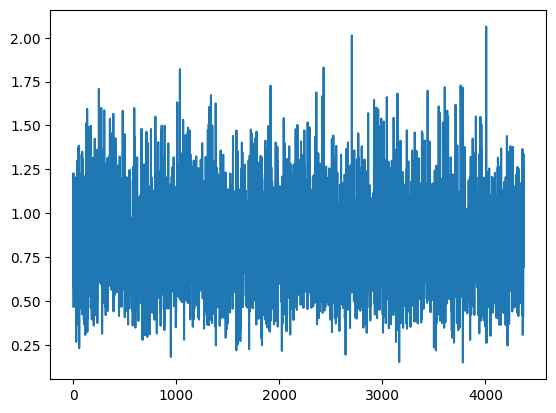

In [176]:
import matplotlib.pyplot as plt
plt.plot(lossi)

In [ ]:
outs.shape

(7000, 144)

In [ ]:
valid_df.shape

(7000, 18)

In [ ]:
valid_df

,ID,img_path,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
63000,TRAIN_63000,./train/TRAIN_63000.jpg,10,2,8,5,12,6,3,4,7,1,14,15,11,16,13,9
63001,TRAIN_63001,./train/TRAIN_63001.jpg,2,14,8,3,7,9,1,10,11,15,5,4,12,13,6,16
63002,TRAIN_63002,./train/TRAIN_63002.jpg,10,11,14,1,12,2,16,7,8,4,5,3,6,9,15,13
63003,TRAIN_63003,./train/TRAIN_63003.jpg,5,16,1,7,3,9,2,13,12,11,8,4,14,6,15,10
63004,TRAIN_63004,./train/TRAIN_63004.jpg,6,9,15,4,1,10,14,2,3,11,12,13,5,16,7,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,TRAIN_69995,./train/TRAIN_69995.jpg,8,4,7,1,2,3,14,10,12,9,13,6,11,16,5,15
69996,TRAIN_69996,./train/TRAIN_69996.jpg,11,9,3,10,4,12,1,6,15,8,5,13,14,7,16,2
69997,TRAIN_69997,./train/TRAIN_69997.jpg,8,16,14,13,5,10,2,3,12,6,7,15,1,11,9,4
69998,TRAIN_69998,./train/TRAIN_69998.jpg,8,15,4,3,2,9,14,7,6,12,5,11,13,1,16,10


In [ ]:
valid_pred_df

,ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
63000,TRAIN_63000,10,3,8,5,12,5,3,4,7,1,14,15,11,16,13,9
63001,TRAIN_63001,1,14,8,4,11,9,1,10,11,15,4,4,12,13,6,16
63002,TRAIN_63002,10,12,13,1,9,2,16,5,9,4,5,2,6,9,15,15
63003,TRAIN_63003,1,16,1,7,4,9,1,13,12,11,8,4,14,6,15,10
63004,TRAIN_63004,3,9,14,4,1,8,16,1,1,2,12,13,5,16,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,TRAIN_69995,8,4,7,1,2,3,14,14,12,9,13,6,12,16,5,14
69996,TRAIN_69996,11,9,4,10,4,12,1,6,15,8,5,13,14,7,16,2
69997,TRAIN_69997,8,16,14,13,5,10,2,3,12,6,7,15,1,11,9,4
69998,TRAIN_69998,8,15,4,3,2,9,14,7,6,12,5,11,13,1,16,10


In [ ]:
test_df[train.]

,ID,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg
...,...,...
59956,TEST_59956,./test/TEST_59956.jpg
59957,TEST_59957,./test/TEST_59957.jpg
59958,TEST_59958,./test/TEST_59958.jpg
59959,TEST_59959,./test/TEST_59959.jpg


In [ ]:
valid_df

In [ ]:
outs = []
model.eval()
with torch.no_grad():
    for x in tqdm(valid_dataloader):
        x = x.to('cuda')
        out = model.forward_test(x) #return x

  0%|          | 0/438 [00:00<?, ?it/s]

In [ ]:
out.shape #batch, length, dim?

torch.Size([8, 144, 256])

In [ ]:
outs1 = []
model.eval()
with torch.no_grad():
    for x in tqdm(valid_dataloader):
        x = x.to('cuda')
        out = model.forward(x) #return x.reshape(-1,-16*16), target.reshape(-1)

  0%|          | 0/438 [00:00<?, ?it/s]

In [ ]:
out

(tensor([[-3.1757e+00, -2.8865e+00, -2.9274e+00,  ..., -7.6336e+01,
          -7.3505e+01, -7.5695e+01],
         [ 6.8997e-02,  7.1812e-02, -9.0699e-01,  ..., -7.5923e+01,
          -7.5812e+01, -7.4675e+01],
         [ 3.4942e+00,  2.0386e+00,  1.5873e+00,  ..., -1.0624e+02,
          -1.0424e+02, -1.0234e+02],
         ...,
         [-8.3573e+00, -8.4038e+00, -8.6963e+00,  ..., -2.4431e+02,
          -2.3775e+02, -2.4408e+02],
         [ 1.1731e+01,  1.1572e+01,  1.1156e+01,  ..., -1.0681e+02,
          -1.0470e+02, -1.0413e+02],
         [ 5.7750e+00,  7.5068e+00,  6.2382e+00,  ..., -1.5749e+02,
          -1.5374e+02, -1.5336e+02]], device='cuda:0'),
 tensor([109, 103,   5,  ...,  41,  44, 113], device='cuda:0'))

In [ ]:
outs = []
model.eval()
with torch.no_grad():
    for x in tqdm(test_dataloader):
        x = x.to('cuda')
        out = model.forward_test(x)
        # out = out[0].reshape(-1,144,16*16)
        out = out.argmax(dim=2).cpu().numpy()
        outs.append(out)

# outs = np.vstack(outs)
# outs
# valid_pred_df = valid_df.copy().drop(columns=['img_path'])

# for I, (idx, row) in enumerate(tqdm(valid_pred_df.iterrows(), total=len(valid_df))):
#     w = outs[I].reshape(12,12)
#     CNT_ROW = np.zeros((4,4,4), dtype=np.int32)
#     CNT_COL = np.zeros((4,4,4), dtype=np.int32)
#     for i in range(12):
#         for j in range(12):
#             ROW = i // 3
#             COL = j // 3
#             v = w[i][j]
#             CNT_ROW[ROW][COL][v // 12 // 3] += 1
#             CNT_COL[ROW][COL][v % 12 // 3] += 1
#     ans = CNT_ROW.argmax(2) * 4 + CNT_COL.argmax(2) + 1
#     ans = ans.reshape(16)
#     ans = list(map(str, ans))
#     valid_pred_df.loc[idx, '1':'16'] = ans
# score = calc_puzzle(valid_df, valid_pred_df)
# print(score)

  0%|          | 0/3748 [00:00<?, ?it/s]

In [ ]:
test_df
submit = pd.read_csv('./jigsaw/sample_submission.csv')

In [ ]:
valid_pred_df

,ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
63000,TRAIN_63000,10,3,8,5,12,5,3,4,7,1,14,15,11,16,13,9
63001,TRAIN_63001,1,14,8,4,11,9,1,10,11,15,4,4,12,13,6,16
63002,TRAIN_63002,10,12,13,1,9,2,16,5,9,4,5,2,6,9,15,15
63003,TRAIN_63003,1,16,1,7,4,9,1,13,12,11,8,4,14,6,15,10
63004,TRAIN_63004,3,9,14,4,1,8,16,1,1,2,12,13,5,16,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19810,NaN,13,3,1,1,4,14,7,9,5,12,15,16,8,16,10,6
19811,NaN,2,15,12,9,14,4,15,11,3,8,2,16,13,5,1,7
19812,NaN,16,4,5,7,10,2,15,3,12,10,1,9,13,6,8,11
19813,NaN,14,15,8,2,9,3,12,4,13,16,5,11,6,7,10,1


In [ ]:
submit

,ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,TEST_00000,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,TEST_00001,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
2,TEST_00002,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
3,TEST_00003,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
4,TEST_00004,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59956,TEST_59956,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
59957,TEST_59957,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
59958,TEST_59958,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
59959,TEST_59959,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16


In [ ]:
outs = np.vstack(outs)
outs
submission = submit.copy()
for I, (idx, row) in enumerate(tqdm(submission.iterrows(), total=len(submit))):
    w = outs[I].reshape(12,12)
    CNT_ROW = np.zeros((4,4,4), dtype=np.int32)
    CNT_COL = np.zeros((4,4,4), dtype=np.int32)
    for i in range(12):
        for j in range(12):
            ROW = i // 3
            COL = j // 3
            v = w[i][j]
            CNT_ROW[ROW][COL][v // 12 // 3] += 1
            CNT_COL[ROW][COL][v % 12 // 3] += 1
    ans = CNT_ROW.argmax(2) * 4 + CNT_COL.argmax(2) + 1
    ans = ans.reshape(16)
    ans = list(map(str, ans))
    submission.loc[idx, '1':'16'] = ans


  0%|          | 0/59961 [00:00<?, ?it/s]

In [ ]:
submission

,ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,TEST_00000,10,9,5,10,16,1,15,12,5,1,5,14,1,6,1,13
1,TEST_00001,14,7,15,10,13,1,8,11,3,16,6,5,12,2,4,9
2,TEST_00002,7,4,14,13,6,15,12,16,5,2,4,1,11,9,10,8
3,TEST_00003,5,12,11,13,14,4,10,6,2,15,16,9,3,7,8,1
4,TEST_00004,1,5,7,10,1,14,3,16,9,6,11,13,12,4,15,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59956,TEST_59956,1,4,4,16,1,13,3,16,16,4,1,13,16,4,16,16
59957,TEST_59957,10,8,2,8,5,7,14,6,16,12,3,1,1,13,9,14
59958,TEST_59958,9,6,16,13,8,15,5,2,11,1,1,11,7,3,13,16
59959,TEST_59959,1,6,9,13,13,5,9,12,12,2,14,2,14,2,8,7


In [ ]:
# prompt: submission csv파일로 저장해줘

submission.to_csv('submission.csv', index=False)


In [ ]:
for idx, xreandtarget in enumerate(out): #out = x.reshape(-1,-16*16), target.reshape(-1)
  print(xreandtarget.shape)

torch.Size([1032, 256])
torch.Size([1032])


In [ ]:
model()

In [ ]:
test_df = pd.read_csv('./jigsaw/test.csv')

In [ ]:
pred_transform = build_transform(is_train = False)

test_dataset = JigsawDataset(
    df=test_df,
    data_path='./jigsaw',
    mode='test',
    transform = valid_transform
)
test_dataloader = DataLoader(test_dataset, batch_size = 16,shuffle = True)



df = pd.read_csv('./jigsaw/train.csv')


train_transform = build_transform(is_train = True)
valid_transform = build_transform(is_train = False)

train_set = JigsawDataset(df = train_df,
                              data_path = './jigsaw',
                              mode = 'train',
                              transform = train_transform)
test_dataset = JigsawDataset(df = test_df,
                              data_path = './jigsaw',
                              mode = 'test',
                              transform = valid_transform)

train_dataloader = DataLoader(
    train_set,
    batch_size = 16,
    shuffle = True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size = 16,
    shuffle = False
)

In [ ]:
# [0 / 4375] loss: 0.8457428812980652
# [400 / 4375] loss: 0.9976324439048767
# [800 / 4375] loss: 0.8630994558334351
# [1200 / 4375] loss: 0.801385223865509
# [1600 / 4375] loss: 0.8121039271354675
# [2000 / 4375] loss: 0.8025326728820801
# [2400 / 4375] loss: 1.0828694105148315
# [2800 / 4375] loss: 0.8235419392585754
# [3200 / 4375] loss: 0.5506572127342224
# [3600 / 4375] loss: 0.3462061882019043
# # [4000 / 4375] loss: 0.7010009288787842

In [ ]:
submission = pd.read_csv('sample_submission')

from transformers import ViTFeatureExtractor, ViTForImageClassification
# # from PIL import Image
# # import requests
# # image = Image.open(requests.get(url, stream=True).raw)
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch16-384')
model = ViTForImageClassification.from_pretrained('google/vit-large-patch16-384')
# # inputs = feature_extractor(images=image, return_tensors="pt")
# # outputs = model(**inputs)
# # logits = outputs.logits


# from transformers import AutoProcessor, AutoModel
# model = AutoModel.from_pretrained("google/siglip-large-patch16-384")
# processor = AutoProcessor.from_pretrained("google/siglip-large-patch16-384")